# WBTech task #1
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

Ноутбук посвящен качественному сравнению двух моделей:
* кастомного ViT с одним простейшим трансформерным блоком энкодера
* дообученная ViT с более высоким разрешением и большим объемом обучаемого множества

### Данные


In [ ]:
# подключаемся к диску

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive

Mounted at /content/drive

/content/drive/My Drive


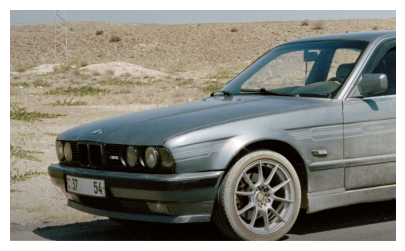

In [ ]:
# проверим подключение

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = './wbtech_data/'
plt.figure(figsize=(5,3))
plt.imshow(mpimg.imread(basepath+'car.png'))
plt.axis('off')
None

Создаем несколько нужных утилит:
* `plot_images()`: семплирует и выводит изображения с соответствующими лейблами
* `load_cifar()`: подгружает CIFAR с препроцессингом
* `cache_batches()`: кэширует CIFAR, полученный в результате `load_cifar()`
* `create_checkpoint()`: создает дерикторию для нового чекпоинта

In [1]:
import torch
import torchvision
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

basepath = './data/vision/'

def plot_images(dataloader, label2title, 
                k=10, rows=1, cols=4, canvas_size=12,
                model=None, device=None, 
                labels=None):
    """
    рандомный сэмплинг k (k>=rows*cols) изображений из случайного батча из даталоудера 
    dataloader типа torch.Tensor и их рисование на графике rows x cols с учетом размерности CxHxW.
    Также доступна явная передача модели для совершения с помощью нее предсказаний.
    """
    imgs, labels = next(iter(dataloader)) # случайный батч из даталоудера

    # предсказываем лэйблы
    if model is not None:
        model.eval()
        with torch.no_grad():
            labels_out = model(imgs.to(device)).cpu() # пробиты по батчам
            labels = torch.softmax(labels_out,dim=1).argmax(dim=1).flatten()
        model.train()

    # рандомный семпл @ k
    rand_indices = torch.randperm(imgs.shape[0])[:k]
    sample = imgs[rand_indices].cpu()
    labels_sample = labels[rand_indices].cpu()

    # инверсивный скейлинг [-1, 1] -> [0, 255]
    sample = (sample.clamp(-1,1) + 1) / 2
    sample = (sample * 255).type(torch.uint8)
    # CxHxW -> Hx(WxK)xC
    inverse_resize = T.Resize((32,32))
    sample = [inverse_resize(image) for image in sample]
    sample = torch.cat(
        [torch.cat(sample, dim=-1)],
    dim=-2).permute(1,2,0)
    # Hx(WxK)xC -> KxHxWxC
    sample = sample.reshape(sample.shape[0],k,sample.shape[1]//k,3).permute(1,0,2,3)

    fig, axs = plt.subplots(rows, cols, figsize=(canvas_size,canvas_size))
    for i in range(rows*cols):
        img, label = sample[i], label2title[labels_sample[i].item()]
        x, y = i % cols, i % rows
        if rows > 1 and cols > 1:
            axs[y, x].imshow(img)
            axs[y, x].set_title(label)
            axs[y, x].axis('off')
        else:
            axs[max(y, x)].imshow(img)
            axs[max(y, x)].set_title(label)
            axs[max(y, x)].axis('off')
    fig.tight_layout()
    fig.show()

def load_cifar(args):
    """
    Загрузка изображений в `args['dataset_path']`
    с предварительным переводом пикселей к [-1, 1]
    и размерностей к CxHxW
    """
    channel_means = (.5,.5,.5)
    channel_stds = (.5,.5,.5)

    transforms = torchvision.transforms.Compose([
        # изначальный размер cifar'а 32x32. Нам нужно добавить
        # немного стохастичности на следующем шаге, для чего мы
        # немного вытягиваем наше изображение
        torchvision.transforms.Resize(512),

        torchvision.transforms.RandomResizedCrop(
            args['img_size'], scale=(.8, 1.0)),

        # скейлинг от [0, 255] к [0, 1] и перевод из HxWxC к CxHxW, который
        # лучше подходит для CNN, а точнее для пуллинга
        torchvision.transforms.ToTensor(),

        # z-скор нормализация и перевод ОДЗ из [0, 1] -> [-1, 1]
        torchvision.transforms.Normalize(
            channel_means, channel_stds)
    ])
    dataset = torchvision.datasets.CIFAR10(
        root=f"{basepath}{args['dataset_path']}",
        train=True,
        transform=transforms,
        download=True)
    dataloader = DataLoader(dataset, batch_size=args['batch_size'],
                            shuffle=True, num_workers=0)
    return dataloader

def cache_batches(dl):
    """
    Кэшируем даталоудер, чтобы не тратить ресурсы на трансформации
    """
    batches = []
    for batch in tqdm(dl):
        batches.append(batch)
    return batches

def create_checkpoint(run_name,
                      base_dir='wbtech_tasks', task_dir='task1/'):
    models_dir = os.path.join(base_dir,'models')
    results_dir = os.path.join(base_dir,'results')
    rundir_m, rundir_r = os.path.join(models_dir, run_name), \
        os.path.join(results_dir, run_name)

    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(rundir_m, exist_ok=True)
    os.makedirs(rundir_r, exist_ok=True)

    return rundir_m, rundir_r

Замечания к следующим выбранным параметрам:
* `img_size=128`: 128 гарантирует всего лишь треть заполненности RAM. Даже уже 256 не гарантирует кэширования датасета полностью (проверенно на кэггле):

    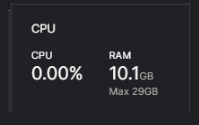

* `batch_size=256`: позволяет закэшировать изображения менее, чем за 5 минут. Тут явно требуются улучшения, так как закэшировать даталоудер без вторичных библиотек я пока не знаю как **[TODO]**.

In [2]:
# подгружаем датасет

training_args = {
    'dataset_path': 'cifar/', # сохранение датасетов
    'models_path': 'task1/', # сохрнение чекпоинтов
    'batch_size': 256,
    'img_size': 128,
}

train_dl = load_cifar(training_args)
len(train_dl)

Files already downloaded and verified


196

In [3]:
# кэшируем батчи из датасета

train_dl = cache_batches(train_dl)

100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


C:\Users\user\AppData\Local\Temp\ipykernel_14984\281652573.py:61: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



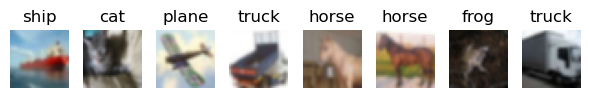

In [89]:
# проверка загруженных изображений

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_images(train_dl, 
            labels2title,
            k=8,cols=8,rows=1,
            canvas_size=6)

### Модель

На основе [лидерборда](https://paperswithcode.com/sota/image-classification-on-cifar-10) по CIFAR10 ViT бъют классические CNN'ы и ResNet'ы, поэтому целью разработки модели стала имплементация ViT с нуля с учтом ограничений в моих вычислительных ресурсах (GPU VRAM 8GB):
* $1$ слой mha-энкодера
* $16$ - пэтч-сайз
* абсолютный позиционный эмбеддинг

Особенности ViT:
* Вместо сверток изображение делится на flattened-patches, количество которых отвечает за контекстную длину `max_seq_len`, как в NLP-задачах. `embed_dims`, аналогично обычным seq2seq задачам, задаются в явном виде
* В пэтч-эмбеддинге по-прежнему используется `conv2d` слой для того, чтобы провести скейлинг HxW -> patch x patch, а также перейти от традиционных каналов, как размерностей, к более подходящим для трансформеров - `embed_dims`:

    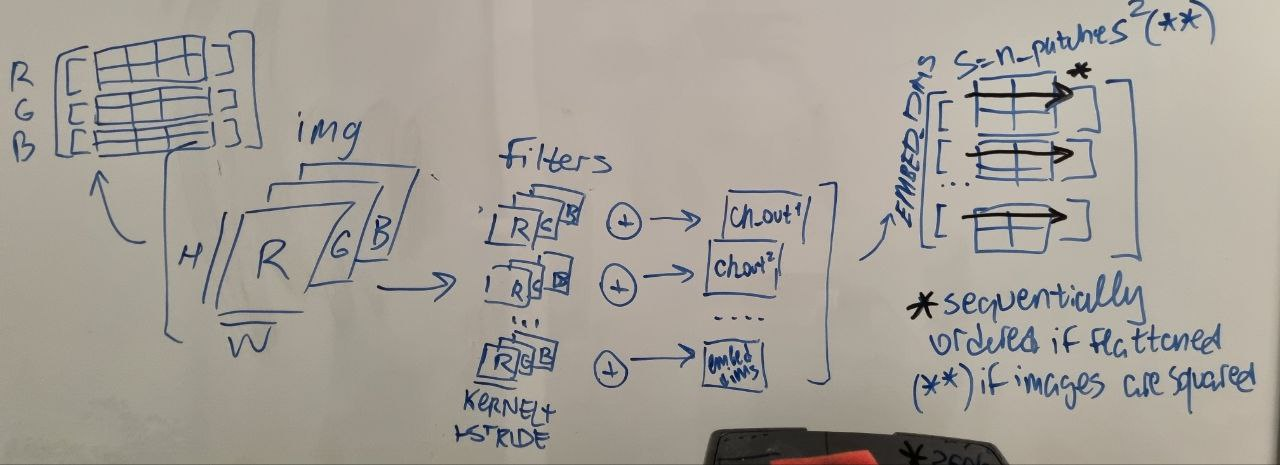

In [4]:
# создание основного пэтч-эмбеддинг модуля
# который выдает эмбеддинг размера (объем контекста, размерность)
# на каждое изображение

from torch import nn
import torch.functional as F

training_args['ch_in'] = 3
training_args['patch_size'] = 16
training_args['embed_dims'] = 1024

class patchEmbedSquared(nn.Module):
  """
  Создание пэтч-эмбеддинга для квадратных
  изображений (H=W)
  """

  def __init__(self, img_size, ch_in, patch_size, embed_dims):
    """
    - img_size: int
      - hxw изображений
    - ch_in: int
      - число каналов
    - patch_size: int
      - размер каждого patch-ядра
      последовательных фреймов изображения (патчей)
    - embed_dims: int
      - модальность эмбеддингов
    """
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches =  (img_size // patch_size) ** 2

    self.proj = nn.Conv2d(
        ch_in,
        embed_dims,
        kernel_size=patch_size, # размер ядра
        stride=patch_size # размер шага ядра
    )

  def forward(self, x):
    """
    Выводит тензор размера (batch_size, n_patches, embed_dims)
    """
    x = self.proj(x)

    # преобразование 2d -> 1d, начиная со индекса размерностей "2"
    # получаем одномерный тензор на каждый embed_dims размера n_patches
    x = x.flatten(2)

    return x.permute(0, 2, 1)

pes = patchEmbedSquared(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims']
)

# размер батча 4, размер изображения 44, размер пэтча - 22, следовательно
# размер контекста равен (44/22)x(44/22)=4 пэтчам каждый размерностью в 128
pes(next(iter(train_dl))[0]).shape

torch.Size([256, 64, 1024])

In [5]:
# совмещаем пэтч-эмбеддинг с позиционным эмебеддингом в рамках
# одного класса

class Embedding(nn.Module):

  def __init__(self, img_size, ch_in,
               patch_size, embed_dims,
               dropout=.2, log_base=10_000,
               device='cpu'):
    super().__init__()
    self.device = device
    self.log_base = torch.tensor(log_base)
    self.embed_dims = embed_dims
    self.context_length = (img_size // patch_size) ** 2
    self.cls_token_embed = nn.Embedding(1,embed_dims)
    self.pes = patchEmbedSquared(
        img_size, ch_in, patch_size, embed_dims
    )
    self.dropout = nn.Dropout(dropout)

  def gen_pos_embed(self):
    """
    Позиционный эмбеддинг из статьи про attention
    """
    image_context_and_cls = self.context_length + 1
    position = torch.arange(image_context_and_cls).unsqueeze(1)
    inf_freq = torch.exp(torch.arange(0, self.embed_dims, 2) * \
                         (-torch.log(self.log_base) / self.embed_dims))
    pe = torch.zeros(image_context_and_cls, 1, self.embed_dims)
    pe[:, 0, 0::2] = torch.sin(position * inf_freq)
    pe[:, 0, 1::2] = torch.cos(position * inf_freq)
    return pe.permute(1,0,2)

  def forward(self, x):
    x = self.pes(x)
    batch_size, context_len = x.shape[0], x.shape[1]
    pos_x = self.gen_pos_embed().expand(
        batch_size, context_len+1, self.embed_dims
    ).to(self.device)
    # добавляем дополнительный токен класса, аналогично алгоритму
    # обучения берта
    cls_x = self.cls_token_embed(
        torch.zeros(pos_x.shape[0], 1).type(torch.int).to(self.device))
    x = torch.cat([cls_x, x], dim=-2)
    return self.dropout(x + pos_x)

emb = Embedding(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims'],
)
emb(next(iter(train_dl))[0]).shape

torch.Size([256, 65, 1024])

In [6]:
# инициализация непосредственного ViT
# (я не пишу кастомную имплементацию MHA + трансформера, так как
# у меня уже таковые есть в портфолио)

class vit(nn.Module):

  def __init__(self, img_size, ch_in,
               patch_size, embed_dims,
               num_classes,class_w=None,
               num_heads=6, num_blocks=3,
               dropout=.1, log_base=10_000,
               device='cpu'):
    super().__init__()

    # позиционный эмбеддинг + пэтч-эмбеддинг
    self.context_length = (img_size // patch_size) ** 2
    self.emb = Embedding(img_size, ch_in, patch_size,
                         embed_dims, dropout, log_base, device)

    # трансформерный энкодер и его компоненты
    self.norm = nn.LayerNorm(embed_dims)
    self.encoder_block = nn.TransformerEncoderLayer(embed_dims, num_heads,
                                                    batch_first=True)
    self.encoder_blocks = nn.TransformerEncoder(self.encoder_block, num_blocks,
                                                self.norm)
    self.fc_out = nn.Linear(embed_dims, num_classes)


  def forward(self, x):
    """
    Возвращает вероятностное поклассовое распределение (batch_size, num_classes)
    """
    x = self.emb(x)
    x = self.encoder_blocks(x)
    out = self.fc_out(x)[:,0] # вытягиваем CLS токен
    return out

training_args['num_classes'] = 10 # CIFAR10 имеет 10 уникальных классов
training_args['num_heads'] = 16
training_args['dropout'] = .1
training_args['num_blocks'] = 1
training_args['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

vit_model = vit(
    training_args['img_size'],
    training_args['ch_in'],
    training_args['patch_size'],
    training_args['embed_dims'],
    training_args['num_classes'],
    num_heads=training_args['num_heads'],
    num_blocks=training_args['num_blocks'],
    dropout=training_args['dropout'],
    device=training_args['device']
).to(training_args['device'])
vit_model

vit(
  (emb): Embedding(
    (cls_token_embed): Embedding(1, 1024)
    (pes): patchEmbedSquared(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (encoder_block): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
    )
    (linear1): Linear(in_features=1024, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=1024, bias=True)
    (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (s

### Обучение

Выбор параметров для обучения будет следующим:
* **RMSProp** (аналогично [статье, посвященной тюнингу ViT](https://arxiv.org/pdf/2211.09359))
* **Cosine LR** в качестве шедулера (аналогично той же статье)
* **Cross-entropy** функцию потерь
* **120 эпох**, чтобы выжить максимум из коллаба по временным ограничениям к GPU-среде

In [8]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [13]:
# инициализируем параметры

torch.cuda.empty_cache()

training_args['max_epochs'] = 200
training_args['wanb_workspace'] = 'wbtech' # воркспейс в w&b для записи экспериментов
training_args['verbose_level'] = 1 # шаг логгирования
training_args['checkin_at'] = 5 # шаг сохранения чекпоинтов

# Adam-like оптимизаторы
training_args['lr'] = .0002
training_args['beta0'] = .9
training_args['beta1'] = .999
training_args['lambda'] = .01
optimizer = torch.optim.AdamW(
    vit_model.parameters(),
    lr=training_args['lr'],
    weight_decay=training_args['lambda']
)

# инциализация оптимизаторов с моментами
training_args['momentum'] = .05
sgd_optimizer = torch.optim.SGD(
    vit_model.parameters(),
    lr=training_args['lr'],
    momentum=training_args['momentum'],
    weight_decay=training_args['lambda']
)
rms_optimizer = torch.optim.RMSprop(
    vit_model.parameters(),
    lr=training_args['lr'],
    momentum=training_args['momentum'],
    weight_decay=training_args['lambda']
)

# ванильный шедулер снижения на плато
training_args['gamma'] = .4 # % от lr для уменьшения
training_args['patience'] = 5
lr_plateu_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=training_args['patience'], factor=training_args['gamma'])

# косинусный шедулер
training_args['eta_min'] = 1e-8
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    len(train_dl),
    eta_min=training_args['eta_min'])

# экспоненциальный шедулер
exponential_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, training_args['gamma'])

# функция потерь
criterion = nn.CrossEntropyLoss().to(training_args['device'])

In [14]:
# запускаем обучение

from tqdm import tqdm
from sklearn.metrics import accuracy_score as acc
import wandb

wandb.init(
    project=training_args['wanb_workspace'],
    name="AdamW + cosineLR",
    config={
    "learning_rate": training_args['lr'],
    "scheduler": "cosineLR",
    "optimizer": "AdamW",
    "architecture": "ViT",
    "dataset": "CIFAR10",
    "epochs": training_args['max_epochs'],
    }
)

avLosses, accuracies = [], []

training_args['run_name'] = 'run1'

for epoch in range(training_args['max_epochs']):
    losses = []
    y, yHat = [], []
    pbar = tqdm(train_dl)
    for (img_batch, label_batch) in pbar:
        img_batch = img_batch.to(training_args['device'])
        label_batch = label_batch.to(training_args['device'])

        optimizer.zero_grad()
        out = vit_model(img_batch)
        loss = criterion(out, label_batch)
        # потенциально можно добавить сюда еще градиентный клиппинг
        loss.backward()
        optimizer.step()
        cosine_scheduler.step()

        pbar.set_postfix(loss=loss.item())
        losses.append(loss.detach().cpu())
        y.append(label_batch.detach().cpu())
        yHat.append(out.detach().cpu().argmax(dim=1).flatten())

    y, yHat = torch.hstack(y), torch.hstack(yHat)
    avLosses.append(torch.hstack(losses).mean().item())
    accuracies.append(acc(y,yHat))

    # логгирование значений метрик
    wandb.log({"av. loss": avLosses[-1], "accuracy": accuracies[-1]})
    if epoch % training_args['verbose_level'] == 0:
        print(f'epoch: {epoch+1} :: av. loss:',avLosses[-1],':: acc:',accuracies[-1])

    # сохранение чекпоинта
    if epoch % training_args['checkin_at'] == 0:
      model_dir, _ = create_checkpoint(training_args['run_name'])
      torch.save(vit_model, os.path.join(model_dir,f'model-chekpoint{epoch}.pth'))
      print(f'registered checkpoint to model-chekpoint{epoch}.pth')

# дисконнектимся от w&b
wandb.finish()

del losses
del y
del yHat
del _

accuracy,▁▆▆▅▇▇▆▆▆▇▇▇▆▇▇▇▇▇▆▇▇▆▇▇▆▇▇▇▇▇█▇█▆▆▇▇▇▇
av. loss,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.29156
av. loss,1.9359


100%|██████████| 196/196 [01:04<00:00,  3.03it/s, loss=1.72]


epoch: 1 :: av. loss: 1.7722456455230713 :: acc: 0.36258
registered checkpoint to model-chekpoint0.pth


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.5]


epoch: 2 :: av. loss: 1.5608993768692017 :: acc: 0.44346


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.44]


epoch: 3 :: av. loss: 1.4756748676300049 :: acc: 0.47268


100%|██████████| 196/196 [01:04<00:00,  3.02it/s, loss=1.36]


epoch: 4 :: av. loss: 1.4219121932983398 :: acc: 0.4939


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.23]


epoch: 5 :: av. loss: 1.3762725591659546 :: acc: 0.50662


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.16]


epoch: 6 :: av. loss: 1.335493803024292 :: acc: 0.5232
registered checkpoint to model-chekpoint5.pth


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=1.1]


epoch: 7 :: av. loss: 1.3063454627990723 :: acc: 0.53322


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=1.05]


epoch: 8 :: av. loss: 1.2788214683532715 :: acc: 0.5454


100%|██████████| 196/196 [01:05<00:00,  3.00it/s, loss=0.993]


epoch: 9 :: av. loss: 1.2528901100158691 :: acc: 0.55112


100%|██████████| 196/196 [01:04<00:00,  3.02it/s, loss=0.953]


epoch: 10 :: av. loss: 1.2308721542358398 :: acc: 0.56216


100%|██████████| 196/196 [01:05<00:00,  3.01it/s, loss=0.858]


epoch: 11 :: av. loss: 1.207005500793457 :: acc: 0.56918
registered checkpoint to model-chekpoint10.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.933]


epoch: 12 :: av. loss: 1.1842973232269287 :: acc: 0.5778


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.798]


epoch: 13 :: av. loss: 1.1661500930786133 :: acc: 0.58542


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.752]


epoch: 14 :: av. loss: 1.148798942565918 :: acc: 0.59252


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.732]


epoch: 15 :: av. loss: 1.1283552646636963 :: acc: 0.5983


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.675]


epoch: 16 :: av. loss: 1.1202874183654785 :: acc: 0.60378
registered checkpoint to model-chekpoint15.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.649]


epoch: 17 :: av. loss: 1.1029794216156006 :: acc: 0.60876


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.66]


epoch: 18 :: av. loss: 1.0778735876083374 :: acc: 0.61566


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.592]


epoch: 19 :: av. loss: 1.0642708539962769 :: acc: 0.62234


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.59]


epoch: 20 :: av. loss: 1.0513004064559937 :: acc: 0.62558


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.563]


epoch: 21 :: av. loss: 1.0324214696884155 :: acc: 0.63272
registered checkpoint to model-chekpoint20.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.575]


epoch: 22 :: av. loss: 1.012804388999939 :: acc: 0.63888


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.473]


epoch: 23 :: av. loss: 1.001852035522461 :: acc: 0.64628


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.472]


epoch: 24 :: av. loss: 0.9826152324676514 :: acc: 0.6538


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.439]


epoch: 25 :: av. loss: 0.9650673866271973 :: acc: 0.6583


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.328]


epoch: 26 :: av. loss: 0.9482241272926331 :: acc: 0.66462
registered checkpoint to model-chekpoint25.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.32]


epoch: 27 :: av. loss: 0.9274145364761353 :: acc: 0.67198


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.359]


epoch: 28 :: av. loss: 0.9142311215400696 :: acc: 0.67752


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.369]


epoch: 29 :: av. loss: 0.8973316550254822 :: acc: 0.6821


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.339]


epoch: 30 :: av. loss: 0.884339451789856 :: acc: 0.68748


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.324]


epoch: 31 :: av. loss: 0.8657110333442688 :: acc: 0.6956
registered checkpoint to model-chekpoint30.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.288]


epoch: 32 :: av. loss: 0.8606047630310059 :: acc: 0.69812


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.265]


epoch: 33 :: av. loss: 0.8519893288612366 :: acc: 0.70014


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.259]


epoch: 34 :: av. loss: 0.8347249031066895 :: acc: 0.70596


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.357]


epoch: 35 :: av. loss: 0.8195397257804871 :: acc: 0.71328


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.254]


epoch: 36 :: av. loss: 0.8125361800193787 :: acc: 0.71528
registered checkpoint to model-chekpoint35.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.212]


epoch: 37 :: av. loss: 0.7972913980484009 :: acc: 0.72112


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.248]


epoch: 38 :: av. loss: 0.7715179324150085 :: acc: 0.73034


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.209]


epoch: 39 :: av. loss: 0.7621293067932129 :: acc: 0.7339


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.193]


epoch: 40 :: av. loss: 0.7461633682250977 :: acc: 0.73994


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.187]


epoch: 41 :: av. loss: 0.7305365800857544 :: acc: 0.74634
registered checkpoint to model-chekpoint40.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.18]


epoch: 42 :: av. loss: 0.7236368656158447 :: acc: 0.74914


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.147]


epoch: 43 :: av. loss: 0.7054219245910645 :: acc: 0.75478


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.14]


epoch: 44 :: av. loss: 0.6886298656463623 :: acc: 0.76322


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.148]


epoch: 45 :: av. loss: 0.6785197854042053 :: acc: 0.76536


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.106]


epoch: 46 :: av. loss: 0.6659904718399048 :: acc: 0.76912
registered checkpoint to model-chekpoint45.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.105]


epoch: 47 :: av. loss: 0.6547600626945496 :: acc: 0.77368


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.127]


epoch: 48 :: av. loss: 0.6341705918312073 :: acc: 0.7827


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.122]


epoch: 49 :: av. loss: 0.6315411925315857 :: acc: 0.78222


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.105]


epoch: 50 :: av. loss: 0.6136957406997681 :: acc: 0.79126


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.11]


epoch: 51 :: av. loss: 0.6005756855010986 :: acc: 0.79314
registered checkpoint to model-chekpoint50.pth


100%|██████████| 196/196 [01:05<00:00,  2.99it/s, loss=0.133]


epoch: 52 :: av. loss: 0.5914677381515503 :: acc: 0.79788


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.133]


epoch: 53 :: av. loss: 0.5805776119232178 :: acc: 0.8024


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0942]


epoch: 54 :: av. loss: 0.5587921738624573 :: acc: 0.80962


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.101]


epoch: 55 :: av. loss: 0.553625762462616 :: acc: 0.8119


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0907]


epoch: 56 :: av. loss: 0.5536140203475952 :: acc: 0.81296
registered checkpoint to model-chekpoint55.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.068]


epoch: 57 :: av. loss: 0.5385279655456543 :: acc: 0.81664


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0848]


epoch: 58 :: av. loss: 0.5367729067802429 :: acc: 0.81952


100%|██████████| 196/196 [01:06<00:00,  2.94it/s, loss=0.0838]


epoch: 59 :: av. loss: 0.519321084022522 :: acc: 0.82234


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.105]


epoch: 60 :: av. loss: 0.5252547860145569 :: acc: 0.82294


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.091]


epoch: 61 :: av. loss: 0.5106920003890991 :: acc: 0.82682
registered checkpoint to model-chekpoint60.pth


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0765]


epoch: 62 :: av. loss: 0.5039688944816589 :: acc: 0.8279


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.12]


epoch: 63 :: av. loss: 0.5029413104057312 :: acc: 0.83128


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0695]


epoch: 64 :: av. loss: 0.48766228556632996 :: acc: 0.83556


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0639]


epoch: 65 :: av. loss: 0.48859333992004395 :: acc: 0.83638


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0728]


epoch: 66 :: av. loss: 0.4742394983768463 :: acc: 0.84062
registered checkpoint to model-chekpoint65.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0771]


epoch: 67 :: av. loss: 0.48059993982315063 :: acc: 0.83782


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.103]


epoch: 68 :: av. loss: 0.46007299423217773 :: acc: 0.84564


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0701]


epoch: 69 :: av. loss: 0.4635159373283386 :: acc: 0.84428


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.0424]


epoch: 70 :: av. loss: 0.4478009343147278 :: acc: 0.85026


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0678]


epoch: 71 :: av. loss: 0.4497879147529602 :: acc: 0.84868
registered checkpoint to model-chekpoint70.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0578]


epoch: 72 :: av. loss: 0.4397132992744446 :: acc: 0.84934


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0866]


epoch: 73 :: av. loss: 0.43680840730667114 :: acc: 0.8535


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0263]


epoch: 74 :: av. loss: 0.4256058633327484 :: acc: 0.85776


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0825]


epoch: 75 :: av. loss: 0.4223569631576538 :: acc: 0.86016


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0632]


epoch: 76 :: av. loss: 0.41800418496131897 :: acc: 0.85934
registered checkpoint to model-chekpoint75.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0415]


epoch: 77 :: av. loss: 0.4177238941192627 :: acc: 0.8593


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.106]


epoch: 78 :: av. loss: 0.40782275795936584 :: acc: 0.86338


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0362]


epoch: 79 :: av. loss: 0.3953203558921814 :: acc: 0.86886


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.054]


epoch: 80 :: av. loss: 0.3930763602256775 :: acc: 0.86938


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0749]


epoch: 81 :: av. loss: 0.39195114374160767 :: acc: 0.86852
registered checkpoint to model-chekpoint80.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0365]


epoch: 82 :: av. loss: 0.3881925344467163 :: acc: 0.87034


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0275]


epoch: 83 :: av. loss: 0.38115766644477844 :: acc: 0.87204


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0355]


epoch: 84 :: av. loss: 0.36850446462631226 :: acc: 0.87658


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0461]


epoch: 85 :: av. loss: 0.36927667260169983 :: acc: 0.87542


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0518]


epoch: 86 :: av. loss: 0.36226338148117065 :: acc: 0.87782
registered checkpoint to model-chekpoint85.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0511]


epoch: 87 :: av. loss: 0.35655924677848816 :: acc: 0.88034


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0362]


epoch: 88 :: av. loss: 0.35938432812690735 :: acc: 0.87922


100%|██████████| 196/196 [01:05<00:00,  2.98it/s, loss=0.034]


epoch: 89 :: av. loss: 0.35138043761253357 :: acc: 0.88316


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0811]


epoch: 90 :: av. loss: 0.3574964106082916 :: acc: 0.8781


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0195]


epoch: 91 :: av. loss: 0.3462751805782318 :: acc: 0.88256
registered checkpoint to model-chekpoint90.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0335]


epoch: 92 :: av. loss: 0.3401247262954712 :: acc: 0.88654


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0646]


epoch: 93 :: av. loss: 0.3366927206516266 :: acc: 0.8864


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0727]


epoch: 94 :: av. loss: 0.33738699555397034 :: acc: 0.8879


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0899]


epoch: 95 :: av. loss: 0.3360525965690613 :: acc: 0.88726


100%|██████████| 196/196 [01:06<00:00,  2.94it/s, loss=0.0421]


epoch: 96 :: av. loss: 0.32934197783470154 :: acc: 0.88984
registered checkpoint to model-chekpoint95.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0233]


epoch: 97 :: av. loss: 0.3227565586566925 :: acc: 0.89156


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.021]


epoch: 98 :: av. loss: 0.3168012797832489 :: acc: 0.89378


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0293]


epoch: 99 :: av. loss: 0.3116321563720703 :: acc: 0.89548


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0359]


epoch: 100 :: av. loss: 0.30720385909080505 :: acc: 0.89584


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0248]


epoch: 101 :: av. loss: 0.30433160066604614 :: acc: 0.89758
registered checkpoint to model-chekpoint100.pth


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0302]


epoch: 102 :: av. loss: 0.2969401478767395 :: acc: 0.90024


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0949]


epoch: 103 :: av. loss: 0.3017866313457489 :: acc: 0.89904


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0226]


epoch: 104 :: av. loss: 0.29677584767341614 :: acc: 0.90082


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0207]


epoch: 105 :: av. loss: 0.294922798871994 :: acc: 0.90082


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0322]


epoch: 106 :: av. loss: 0.28101012110710144 :: acc: 0.90532
registered checkpoint to model-chekpoint105.pth


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0736]


epoch: 107 :: av. loss: 0.284931480884552 :: acc: 0.90434


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0283]


epoch: 108 :: av. loss: 0.2819102108478546 :: acc: 0.90546


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0194]


epoch: 109 :: av. loss: 0.28484442830085754 :: acc: 0.90476


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0151]


epoch: 110 :: av. loss: 0.2748737633228302 :: acc: 0.90842


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.04]


epoch: 111 :: av. loss: 0.2708743214607239 :: acc: 0.90798
registered checkpoint to model-chekpoint110.pth


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0279]


epoch: 112 :: av. loss: 0.26977428793907166 :: acc: 0.9084


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0297]


epoch: 113 :: av. loss: 0.26783445477485657 :: acc: 0.90944


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.02]


epoch: 114 :: av. loss: 0.2643987834453583 :: acc: 0.91282


100%|██████████| 196/196 [01:06<00:00,  2.95it/s, loss=0.0557]


epoch: 115 :: av. loss: 0.25982680916786194 :: acc: 0.91256


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.00809]


epoch: 116 :: av. loss: 0.2567960321903229 :: acc: 0.91294
registered checkpoint to model-chekpoint115.pth


100%|██████████| 196/196 [01:05<00:00,  2.97it/s, loss=0.0134]


epoch: 117 :: av. loss: 0.25919586420059204 :: acc: 0.91242


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.0759]


epoch: 118 :: av. loss: 0.2555423378944397 :: acc: 0.9142


100%|██████████| 196/196 [01:06<00:00,  2.97it/s, loss=0.023]


epoch: 119 :: av. loss: 0.25659307837486267 :: acc: 0.91382


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0207]


epoch: 120 :: av. loss: 0.2557052671909332 :: acc: 0.91512


100%|██████████| 196/196 [01:06<00:00,  2.96it/s, loss=0.0248]


epoch: 121 :: av. loss: 0.24704843759536743 :: acc: 0.91614
registered checkpoint to model-chekpoint120.pth


 15%|█▍        | 29/196 [00:10<00:58,  2.83it/s, loss=0.0969]


KeyboardInterrupt: 

In [ ]:
# сохраним результаты метрик в .h5 датасет

metrics_file_path ='./runs/cv/results/cifar_vit.h5'
metrics_file_path = f'./wbtech_tasks/results/'\
    f'{training_args["run_name"]}/metrics.h5'

In [15]:
import h5py
import numpy as np

accuracies, avLosses = np.array(accuracies), \
    np.array(avLosses)
h5f = h5py.File(metrics_file_path, 'w')
h5f.create_dataset('acc', data=accuracies)
h5f.create_dataset('loss', data=avLosses)
h5f.close()

### Оценка результата
Модель с AdamW оптимизатором и косинусным планировщиком показала более-менее близкий к сотам результат в 90%+ на тренировочном множестве:

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import h5py

# подгружаем X и Yi
epochs_range = list(range(120))
with h5py.File(metrics_file_path, 'r') as f:
    avLosses, accuracies = f['loss'][:], f['acc'][:]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('loss', 'accuracy'))
fig.add_trace(
    go.Scatter(x=epochs_range, y=avLosses),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=epochs_range, y=accuracies),
    row=1, col=2
)

fig.update_layout(height=300, width=600,
                  title_text="Кривые обучения",
                  showlegend=False)
fig.show()

Более того, в результате многочисленных экспериментов, AdamW вместе с косинусным шедулером, оказались наиболее подящими для обучения легковесного ViT на небольшом датасете. В этом можно убедиться по графикам средних значений функции потерь, а также top-1 точности:

In [90]:
from IPython.display import IFrame

url_to_report = 'https://wandb.ai/turkunov/wbtech/reports/wbtask_1-ViT-results--Vmlldzo4MjY1MzQ0?accessToken=v6d0m7cqbi4j176gh31jcyake1no2ma4xpb9i3gbt3l0o6gdfc7h5vb3ka9dm9sm'
IFrame(url_to_report, width=600, height=300)

Далее можем визуально оценить индивидуальные предикты на том же тренировочном множестве:

c:\Users\user\miniconda3\envs\intensive\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(
C:\Users\user\AppData\Local\Temp\ipykernel_12260\281652573.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


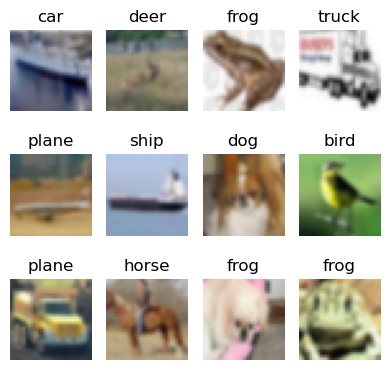

In [7]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
path_to_model = './runs/cv/models/vit/cifar10_vit.pth'
labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
vit_model = torch.load(path_to_model)
plot_images(
    dataloader=train_dl, 
    label2title=labels2title, 
    k=12, 
    rows=3, cols=4, 
    canvas_size=4, 
    model=vit_model, 
    device=device)

## Часть 2


1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


Будет сравнение с популярным ViT'ом (https://huggingface.co/google/vit-base-patch16-224-in21k), который будет зафайнтюнен через LoRA. Предварительно необходимо инициализировать немного другую функцию препроцессинга `load_cifar_for_finetune()` для того, чтобы учесть размер изображений (224), подающийся на вход оригинальной модели:

In [3]:
from datasets import Dataset

def load_cifar_for_finetune(args):
    """
    Адаптация load_cifar
    """
    channel_means = (.5,.5,.5)
    channel_stds = (.5,.5,.5)

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(512),
        torchvision.transforms.RandomResizedCrop(
            224, scale=(.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            channel_means, channel_stds)
    ])
    dataset = torchvision.datasets.CIFAR10(
        root=f"{basepath}{args['dataset_path']}",
        train=True,
        transform=transforms,
        download=True)
    return dataset

train_dl_finetuning = load_cifar_for_finetune(training_args)
len(train_dl_finetuning)

Files already downloaded and verified


50000

In [102]:
# функция для вывода % тренировочных параметров

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"обучаемые параметры модели: {trainable_params} || все параметры: {all_param} || обучаемых%: {100 * trainable_params / all_param:.2f}")

In [103]:
# инициализируем lora-адаптер с рангом QV матриц в 16
# и lora_alpha в 16 (т.е. lr=1)

from peft import LoraConfig, get_peft_model
from transformers import ViTForImageClassification

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels2title),
    id2label={i: c for i, c in enumerate(labels2title)},
    label2id={c: i for i, c in enumerate(labels2title)}
)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


обучаемые параметры модели: 597514 || все параметры: 86403860 || обучаемых%: 0.69


In [6]:
# инициализируем training_args для huggingface.Trainer

from transformers import TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }

batch_size = 16
num_epochs = 300

args = TrainingArguments(
    f"./runs/cv/models/vit/finetuned/cifar_lora/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    report_to='wandb',
    # num_train_epochs=5,
    max_steps=num_epochs, # перезапись num_train_epochs
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
)

In [7]:
# инициализируем тренера
from transformers import Trainer, TrainerCallback
from transformers import AutoImageProcessor
from copy import deepcopy

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)

        if "labels" in inputs:
            preds = outputs.logits.detach()
            acc = (
                (preds.argmax(axis=1) == inputs["labels"])
                .type(torch.float)
                .mean()
                .item()
            )
            self.log({"accuracy": acc})

        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]

        return (loss, outputs) if return_outputs else loss

image_processor = AutoImageProcessor.from_pretrained(model_name)

torch.cuda.empty_cache()

trainer = CustomTrainer(
    lora_model,
    args,
    train_dataset=train_dl_finetuning,
    eval_dataset=train_dl_finetuning,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yturkunov (turkunov). Use `wandb login --relogin` to force relogin


  0%|          | 0/300 [00:00<?, ?it/s]

{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.1875, 'epoch': 0}
{'accuracy': 0.0625, 'epoch': 0}
{'accuracy': 0.0, 'epoch': 0.0}
{'accuracy': 0.0625, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.25, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.1875, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.0}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.1875, 'epoch': 0.01}
{'accuracy': 0.4375, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.125, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.1875, 'epoch': 0.01}
{'accuracy': 0.25, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{'accuracy': 0.3125, 'epoch': 0.01}
{'accuracy': 0.375, 'epoch': 0.01}
{

  0%|          | 0/3125 [00:00<?, ?it/s]

{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.875, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.875, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 0.9375, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 1.0, 'epoch': 0.38}
{'accuracy': 0.9375, 

KeyboardInterrupt: 

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

loss = list(filter(lambda x: x is not None, list(map(lambda x: None if 'loss' not in x.keys() else x['loss'], trainer.state.log_history))))
log_hist = pd.DataFrame(trainer.state.log_history)
accuracy = log_hist['accuracy'].dropna()[:300:5].tolist()

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('loss', 'accuracy'))


fig.add_trace(
    go.Scatter(x=list(range(1,31)), y=loss),
    row=1, col=1
)
fig.update_xaxes(title_text="epoch/10", row=1, col=1)

fig.add_trace(
    go.Scatter(x=list(range(1,301,5)), y=accuracy),
    row=1, col=2
)
fig.update_xaxes(title_text="epoch/5", row=1, col=2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)
fig.show()

Несмотря на то, что мы заморозили большую часть слоев предобученной модели и оставили QV матрицы более низких размерностей (за что и получили намного более высокую скорость обучения на количестве эпох в два раза больше изначальных), мы получили не менее утешительный результат в 96%+ точности на тренировочном множестве. Теперь можно выгрузить модель в публичный доступ на hub:

In [31]:
import os
from dotenv import load_dotenv

load_dotenv()

repo_name = f"yturkunov/cifar10_vit16_lora"
lora_model.push_to_hub(repo_name, token=os.getenv("HF_WRITE_TOKEN"))

adapter_model.safetensors:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yturkunov/cifar10_vit16_lora/commit/158a7ed28b3fab3643fb54162a06da9d30c6783a', commit_message='Upload model', commit_description='', oid='158a7ed28b3fab3643fb54162a06da9d30c6783a', pr_url=None, pr_revision=None, pr_num=None)

После этого мы можем уже загрузить модель и прогнать ее на том же тренировочном множестве. Для начала соединим адаптер с оригинальной моделью:

In [39]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels2title),
    id2label={i: c for i, c in enumerate(labels2title)},
    label2id={c: i for i, c in enumerate(labels2title)}
)
model.load_adapter(repo_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Затем напишем адаптацию `plot_images()` для того, чтобы выводить предикты дообученной hf-модели вместе с изображениями: 

In [100]:
def plot_huggingface_preds(preds, images, label2title, cols, rows, canvas_size):
    """
    адаптация plot_images() для hf-инференса, с убранными лишними условиями

    - preds: torch.tensor
        - логиты классов, получившихся в результате HF-модели
    - images: torch.tensor
        - батч из изображений BxCxHxW
    - resize_bias: int
        - размер изображений для hf-модели
    - cols/rows: int
        - кол-во столбцов, колонок
    canvas_size: int
        - размер холста
    """
    images = (images.clamp(-1,1) + 1) / 2
    images = (images * 255).type(torch.uint8)
    inverse_transform = torchvision.transforms.Resize((32,32))
    images = [inverse_transform(image) for image in images]
    batch_size = len(images)
    images = torch.cat(
        [torch.cat(images, dim=-1)],
    dim=-2).permute(1,2,0)
    images = images.reshape(images.shape[0],batch_size,images.shape[1]//batch_size,3).permute(1,0,2,3)

    fig, axs = plt.subplots(rows, cols, figsize=(canvas_size,canvas_size))
    for i in range(rows*cols):
        img, label = images[i], label2title[preds[i].item()]
        x, y = i % cols, i % rows
        if rows > 1 and cols > 1:
            axs[y, x].imshow(img)
            axs[y, x].set_title(label)
            axs[y, x].axis('off')
        else:
            axs[max(y, x)].imshow(img)
            axs[max(y, x)].set_title(label)
            axs[max(y, x)].axis('off')
    fig.tight_layout()
    fig.show()

Теперь возможно визуально оценить качество предиктов модели:

C:\Users\user\AppData\Local\Temp\ipykernel_7024\1262300455.py:39: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



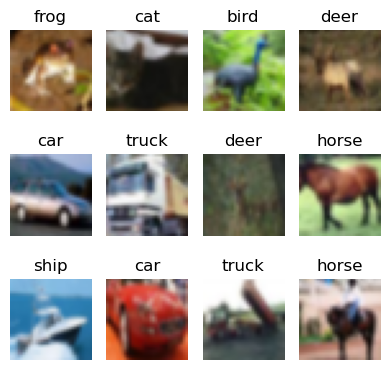

In [101]:
# сэмплируем k первых изображений и выводим предикты модели

k = 12 # количество сэмплов из датасета

image_batch = []
preds = []
for i, il in enumerate(train_dl_finetuning):
    if i == k:
        break
    image_batch.append(il[0][None,:,:,:])
    with torch.no_grad():
        outputs = model(image_batch[-1])
        preds.append(outputs.logits.argmax(-1))

labels2title = ['plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_huggingface_preds(preds=preds,images=torch.cat(image_batch),
                       label2title=labels2title,
                       rows=3,cols=4,canvas_size=4)

## Вывод

Вполне ожидаемым оказался тот факт, что дообучение ViT намного выгоднее по времени и качественным метрикам, нежели чем тренировка кастомных моделей. С другой стороны, полноценное кастомное решение, без замороженных слоев, в отличие от полноценной модели, занимает меньше места при обучении на более требовательных gpu, что дает больше опций для различных экспериментов со слоями и подходами к созданию трансформеров/нормализаций/активаций, так как возможно для достижения той же качественной метрики в действительности на мейнстрим-задаче потребуется меньше слоев.

В любом случае, в качестве бейзлайна лучше брать дообучение модели со снижением размерностей с помощью LoRA, потому что такой подход:
* позволяет быстрее оценить пригодность данных для обучения
* позволяет быстро оценить, при разморозке только QV слоев, насколько механизм внимания вообще подходит под задачу
* позволяет в короткие сроки получить PoC для заказчика с аналогичными, а иногда и более высокими, по сравнению с кастомным решением, метриками